<a href="https://colab.research.google.com/github/Hab-eeb/planet-kaggle/blob/master/Updated_basic_model(firs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np 
import pandas as pd


In [ ]:
!ls /kaggle/input/planets-dataset/planet/planet

sample_submission.csv  test-jpg  train-jpg  train_classes.csv


In [ ]:
import keras as k
from keras.layers import Flatten
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import Dropout 
from keras.layers import Conv2D
from keras.layers import MaxPooling2D 
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
import cv2
from tqdm import tqdm

In [ ]:
x_train = []
y_train = []
x_test = []
x_test2=[]


In [ ]:
df_train =pd.read_csv('/kaggle/input/planets-dataset/planet/planet/train_classes.csv')
df_train.shape

(40479, 2)

In [ ]:
flatten = lambda l : [items for sublist in l for items in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

In [ ]:
label_map = {l:i for i,l in enumerate(labels)}
inv_label_map = {i:l for i,l in enumerate(labels)}


In [ ]:
for f, tags in tqdm(df_train.values, miniters=1000):
    img = cv2.imread("/kaggle/input/planets-dataset/planet/planet/train-jpg/{}.jpg".format(f))
    targets = np.zeros(17)
    for t in tags.split(" "):
        targets[label_map[t]]=1
    x_train.append(cv2.resize(img,(32,32))) 
    y_train.append(targets)

100%|██████████| 40479/40479 [01:36<00:00, 420.26it/s]


In [ ]:
sample_submission_df = pd.read_csv("../input/planets-dataset/planet/planet/sample_submission.csv")


In [ ]:
 !ls ../input/planets-dataset/planet/planet/test-jpg | wc -l

40669


In [ ]:
sample_submission_df_test1 = sample_submission_df['image_name'][:40669]

In [ ]:
sample_submission_df_test1.shape

(40669,)

In [ ]:
sample_submission_df_test2 = sample_submission_df['image_name'][40669:]


In [ ]:
sample_submission_df_test2.shape

(20522,)

In [ ]:

for name in tqdm(sample_submission_df_test1,miniters=1000):
    imge = cv2.imread("../input/planets-dataset/planet/planet/test-jpg/{}.jpg".format(name))
    x_test.append(cv2.resize(imge,(32,32)))
    




100%|██████████| 40669/40669 [01:36<00:00, 420.83it/s]


In [ ]:

for name in tqdm(sample_submission_df_test2,miniters=1000):
    imge2 = cv2.imread("../input/planets-dataset/test-jpg-additional/test-jpg-additional/{}.jpg".format(name))
    x_test2.append(cv2.resize(imge2,(32,32)))
    


100%|██████████| 20522/20522 [00:48<00:00, 422.82it/s]


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

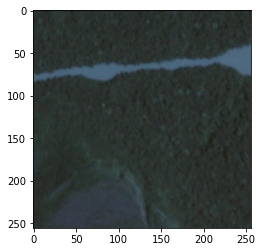

In [ ]:
imge = cv2.imread("../input/planets-dataset/planet/planet/test-jpg/test_20.jpg")
plt.imshow(imge)

In [ ]:
x_test2= np.array(x_test2,np.float16)/255
x_test= np.array(x_test,np.float16)/255
x_train = np.array(x_train,np.float16)/255 
y_train = np.array(y_train,np.uint8)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(x_test2.shape)


(40479, 32, 32, 3)
(40479, 17)
(40669, 32, 32, 3)
(20522, 32, 32, 3)


In [ ]:
split = 37000

x_train,x_val,y_train,y_val = x_train[:split],x_train[split:],y_train[:split],y_train[split:]

In [ ]:
def fbeta(ytrue , ypred, beta=2, epsilon=1e-4):
    beta_squarred = beta**2

    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(0.5)), tf.float32)
        
    tp = tf.reduce_sum(ytrue * ypred, axis=1)
    fp = tf.reduce_sum(ypred, axis=1) - tp
    fn = tf.reduce_sum(ytrue, axis=1) - tp
    
    precision = tp/(tp+fp+epsilon)
    recall = tp/(tp+fn+epsilon)
    
    fb = (1+beta_squarred)*precision*recall / (beta_squarred*precision + recall + epsilon)
    return fb

In [ ]:
def multi_label_acc(ytrue , ypred, epsilon=1e-4):
    
    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(ytrue * ypred, axis=1)
    fp = tf.reduce_sum(ypred, axis=1) - tp
    fn = tf.reduce_sum(ytrue, axis=1) - tp
    
    ytrue = tf.cast(ytrue, tf.bool)
    ypred = tf.cast(ypred, tf.bool)
    
    tn = tf.reduce_sum(tf.cast(tf.logical_not(ytrue), tf.float32) * tf.cast(tf.logical_not(ypred), tf.float32),\
                       axis=1)
    
    return (tp+tn)/(tp+tn+fp+fn+epsilon)

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(32, 32, 3)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))


In [ ]:
opt = Adam(lr=1e-3)
model.compile(loss='binary_crossentropy', 
              optimizer=opt,
              metrics=[multi_label_acc,fbeta])
              


In [ ]:
model.fit(x_train, y_train,batch_size=128,epochs=15,verbose=2,validation_data=(x_val, y_val))
          

Epoch 1/15
290/290 - 2s - loss: 0.0899 - multi_label_acc: 0.9615 - fbeta: 0.8842 - val_loss: 0.1622 - val_multi_label_acc: 0.9485 - val_fbeta: 0.8405
Epoch 2/15
290/290 - 2s - loss: 0.0887 - multi_label_acc: 0.9616 - fbeta: 0.8836 - val_loss: 0.1599 - val_multi_label_acc: 0.9476 - val_fbeta: 0.8403
Epoch 3/15
290/290 - 2s - loss: 0.0890 - multi_label_acc: 0.9616 - fbeta: 0.8841 - val_loss: 0.1631 - val_multi_label_acc: 0.9475 - val_fbeta: 0.8387
Epoch 4/15
290/290 - 2s - loss: 0.0881 - multi_label_acc: 0.9620 - fbeta: 0.8850 - val_loss: 0.1663 - val_multi_label_acc: 0.9477 - val_fbeta: 0.8416
Epoch 5/15
290/290 - 2s - loss: 0.0880 - multi_label_acc: 0.9620 - fbeta: 0.8857 - val_loss: 0.1673 - val_multi_label_acc: 0.9481 - val_fbeta: 0.8418
Epoch 6/15
290/290 - 2s - loss: 0.0871 - multi_label_acc: 0.9622 - fbeta: 0.8863 - val_loss: 0.1639 - val_multi_label_acc: 0.9476 - val_fbeta: 0.8420
Epoch 7/15
290/290 - 2s - loss: 0.0886 - multi_label_acc: 0.9618 - fbeta: 0.8849 - val_loss: 0.1699 

In [ ]:
#model.load_weights("./first_checkpoint")
model.save_weights("./firs_checkpoint")

In [ ]:
pred1 = model.predict(x_test, batch_size=128, verbose=1)

318/318 [==============================] - 1s 2ms/step


In [ ]:
pred1_tags = pd.DataFrame(pred1)
pred1_tags = pred1_tags.apply(lambda x: " ".join(np.array(labels)[x > 0.5]),axis = 1)


In [ ]:
pred1_tags.head()

In [ ]:
result1 = pd.DataFrame({"image_name":sample_submission_df_test1,"tags":pred1_tags})
result1.head()

In [ ]:
pred2 = model.predict(x_test2, batch_size=128, verbose=1)

In [ ]:
pred2_tags = pd.DataFrame(pred2)
pred2_tags = pred2_tags.apply(lambda x: " ".join(np.array(labels)[x > 0.5]),axis = 1)


In [ ]:
pred2_tags.shape

In [ ]:
#sample2 = sample_submission_df.iloc[40669:]["image_name"]

In [ ]:
# result_2= pd.DataFrame({"image_name":sample2,"tags":pred2_tags})
# #result_2[result_2["image_name"]=="file_1"]
# result_2.shape

In [ ]:
result2 = pd.DataFrame({"image_name":sample_submission_df_test2})
result2 = result2.reset_index().drop("index",axis=1)
result2.head()

In [ ]:
tg = pd.DataFrame({"tags":pred2_tags})
tg.head()

In [ ]:
result2['tags']=tg
result2.head()

In [ ]:
result2.shape

In [ ]:
result1.shape

In [ ]:
final_result = pd.concat([result1,result2])
final_result.reset_index(inplace=True)
final_result.drop("index",axis=1,inplace=True)

In [ ]:
final_result.shape

In [ ]:
final_result.to_csv("firs_submission.csv",index=False)